# Iteratively subsetting spatial data by HUC across WA state

In [15]:
library(terra)
library(tidyterra)
library(dplyr)
library(randomForest)
library(stringr)

Bring in all data layers

- WA state polygon
- climate data
- terrain data
- spectral data

In [4]:
wa_shp <- vect("data/wa_shp_diss.gpkg")
# wa_ecoreg <- vect("data/wa_l3_eco/wa_eco_l3.shp") |> project("EPSG:3740") |> tidyterra::select(US_L3NAME)
# wa_ecoreg

In [5]:
ppt <- rast("data/stack_data/PRISM/wa_ppt.tif")
tmean <- rast("data/stack_data/PRISM/wa_tmean.tif")
vpd <- rast("data/stack_data/PRISM/wa_vpd.tif")
clim_stack <- c(ppt, tmean, vpd)

In [6]:
list_files <- list.files(path = "data/stack_data", full.names = TRUE, pattern = ".tif", include.dirs = FALSE)
list_files
terr_stack<- rast(list_files)
terr_stack <- terra::subset(terr_stack, "wa_dinfpoint", negate = TRUE)
terr_stack

[1] "data/stack_data/wa_dem_diss_prj3740.tif"
 [2] "data/stack_data/wa_dev27msk.tif"        
 [3] "data/stack_data/wa_dev3msk.tif"         
 [4] "data/stack_data/wa_dev81msk.tif"        
 [5] "data/stack_data/wa_dinfpoint.tif"       
 [6] "data/stack_data/wa_dinfsca.tif"         
 [7] "data/stack_data/wa_planc.tif"           
 [8] "data/stack_data/wa_profc.tif"           
 [9] "data/stack_data/wa_rugged.tif"          
[10] "data/stack_data/wa_slope_nozero.tif"    
[11] "data/stack_data/wa_twi_nozeroslp.tif"

class       : SpatRaster 
dimensions  : 16959, 25378, 10  (nrow, ncol, nlyr)
resolution  : 23.64304, 23.64304  (x, y)
extent      : 371131.6, 971144.8, 5043580, 5444542  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
sources     : wa_dem_diss_prj3740.tif  
              wa_dev27msk.tif  
              wa_dev3msk.tif  
              ... and 7 more source(s)
names       : NASAD~9w125,  wa_dev27,   wa_dev3,  wa_dev81, wa_dinfsca, wa_planc, ... 
min values  :   -35.65501, -13.49994, -13.55343, -18.42358,         ? ,       ? , ... 
max values  :  4373.03906,  10.51795,  13.55344,  13.27825,         ? ,       ? , ... 

In [7]:
wa_spec<- rast("data/stack_data/Spectral/WA_median_mosaic.tif")
wa_spec <- terra::subset(wa_spec, "uncertainty", negate = TRUE)
wa_spec

class       : SpatRaster 
dimensions  : 13366, 20286, 6  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 362550, 971130, 5043570, 5444550  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source      : WA_median_mosaic.tif 
names       : tree_~cover, NDVI_median, MNDWI_median, EVI_median, SAVI_median, NDYI_median 
min values  :           0,  -0.9962001,   -0.9924589,  -4.290172,  -0.3153680,   -2.461545 
max values  :          86,   0.9955124,    0.9966356,   7.263647,   0.8293253,    2.052344 

Make a data path variable for writing data

In [8]:
datapath <- paste0(getwd(), "/data/huc_data/")
datapath

[1] "/home/ajs0428/WIP Testing/data/huc_data/"

Function to crop and mask the larger WA stack by any defined polygon area within WA such as ecoregions or HUCs 

In [9]:
eco_crop_func <- function(stack, ecoreg, path){
    for(i in 1:length(ecoreg)){
        nameClean <- str_replace_all(paste0(values(ecoreg[i])), "[^[:alnum:]]", "")
        terra::mask(stack, ecoreg[i],
                    filename = paste0(path,deparse(substitute(stack)), paste0(nameClean), ".tif"), 
                   overwrite = TRUE,
                  steps = nrow(stack[[1]])) 
    }
}

The `terra` package can change options to make raster processing more memory efficient. Most important is `memmax` is set smaller (in Gb) to process chunks of the raster faster

In [10]:
terraOptions(memmin = 0.1, memfrac = 0.7, memmax = 0.1)

If the memmax is changed above you will see the number of chunks `nr chunks` change 

In [11]:
terra::mem_info(wa_spec)


------------------------
Memory (GB) 
------------------------
check threshold : 0.1 (memmin)
available       : 0.1 (memmax)
allowed (70%)   : 0.07
needed (n=1)    : 12.12
------------------------
proc in memory  : FALSE
nr chunks       : 248
------------------------


Import HUC dataset and make sure it is in same projection for WA state

In [12]:
hucs <- vect("data/Hydrography/WBD_17_HU2_GPKG.gpkg", layer = "WBDHU8") |>
    terra::project("EPSG:3740") |>
    terra::crop(wa_shp) |> 
    select(name)

hucs

 class       : SpatVector 
 geometry    : polygons 
 dimensions  : 71, 1  (geometries, attributes)
 extent      : 371124.2, 971138, 5043576, 5444546  (xmin, xmax, ymin, ymax)
 coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
 names       :         name
 type        :        <chr>
 values      :  Willapa Bay
               Lower Skagit
               Upper Skagit

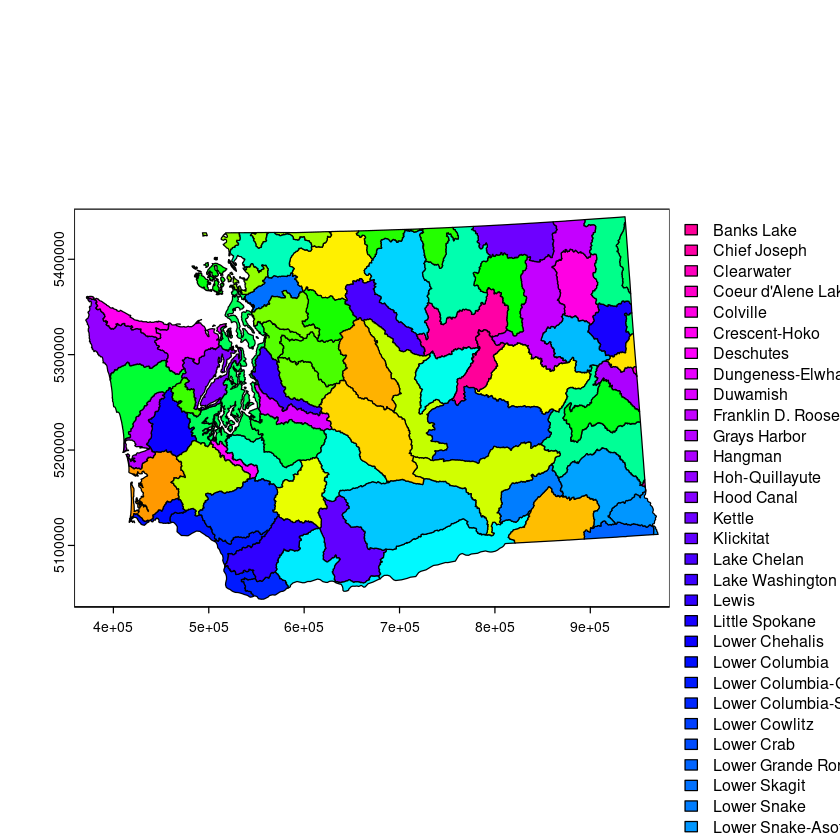

In [13]:
plot(hucs, "name", type = "classes")

Apply function to create subset stacks of data to be used in model building 

In [16]:
paste0(values(hucs[65]))

[1] "Franklin D. Roosevelt Lake"

In [17]:
str_replace_all(paste0(values(hucs[65])), "[^[:alnum:]]", "")

[1] "FranklinDRooseveltLake"

In [18]:
eco_crop_func(clim_stack, hucs, datapath)

In [19]:
eco_crop_func(terr_stack, hucs, datapath)

Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 7 GB.”


Warning message:
“[mask] Estimated disk space needed without compression: 16GB. Available: 8 GB.”


In [20]:
eco_crop_func(wa_spec, hucs, datapath)